# Pacote de Onda Plana

Neste *notebook* verificamos a qualidade da evolução temporal de um pacote de onda gaussiano realizada por três diferentes métodos numéricos:

- Pseudo-Espectral (*Split-Step FFT*)
- Runge-Kutta
- Crank-Nicolson

## Bibliotecas utilizadas

In [1]:
# python standard
import os, time
# from multiprocessing import Pool, TimeoutError

# third-party
import numpy as np
import pandas as pd
from scipy.integrate import simps
import scipy.constants as cte
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
from scipy.stats import norm, skewnorm
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

## Configurações gráficas

In [2]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('mestrado')

# import matplotlib
# import matplotlib.pyplot as plt
# print(plt.style.available)
# print(matplotlib.get_configdir())

## Parâmetros de qualidade

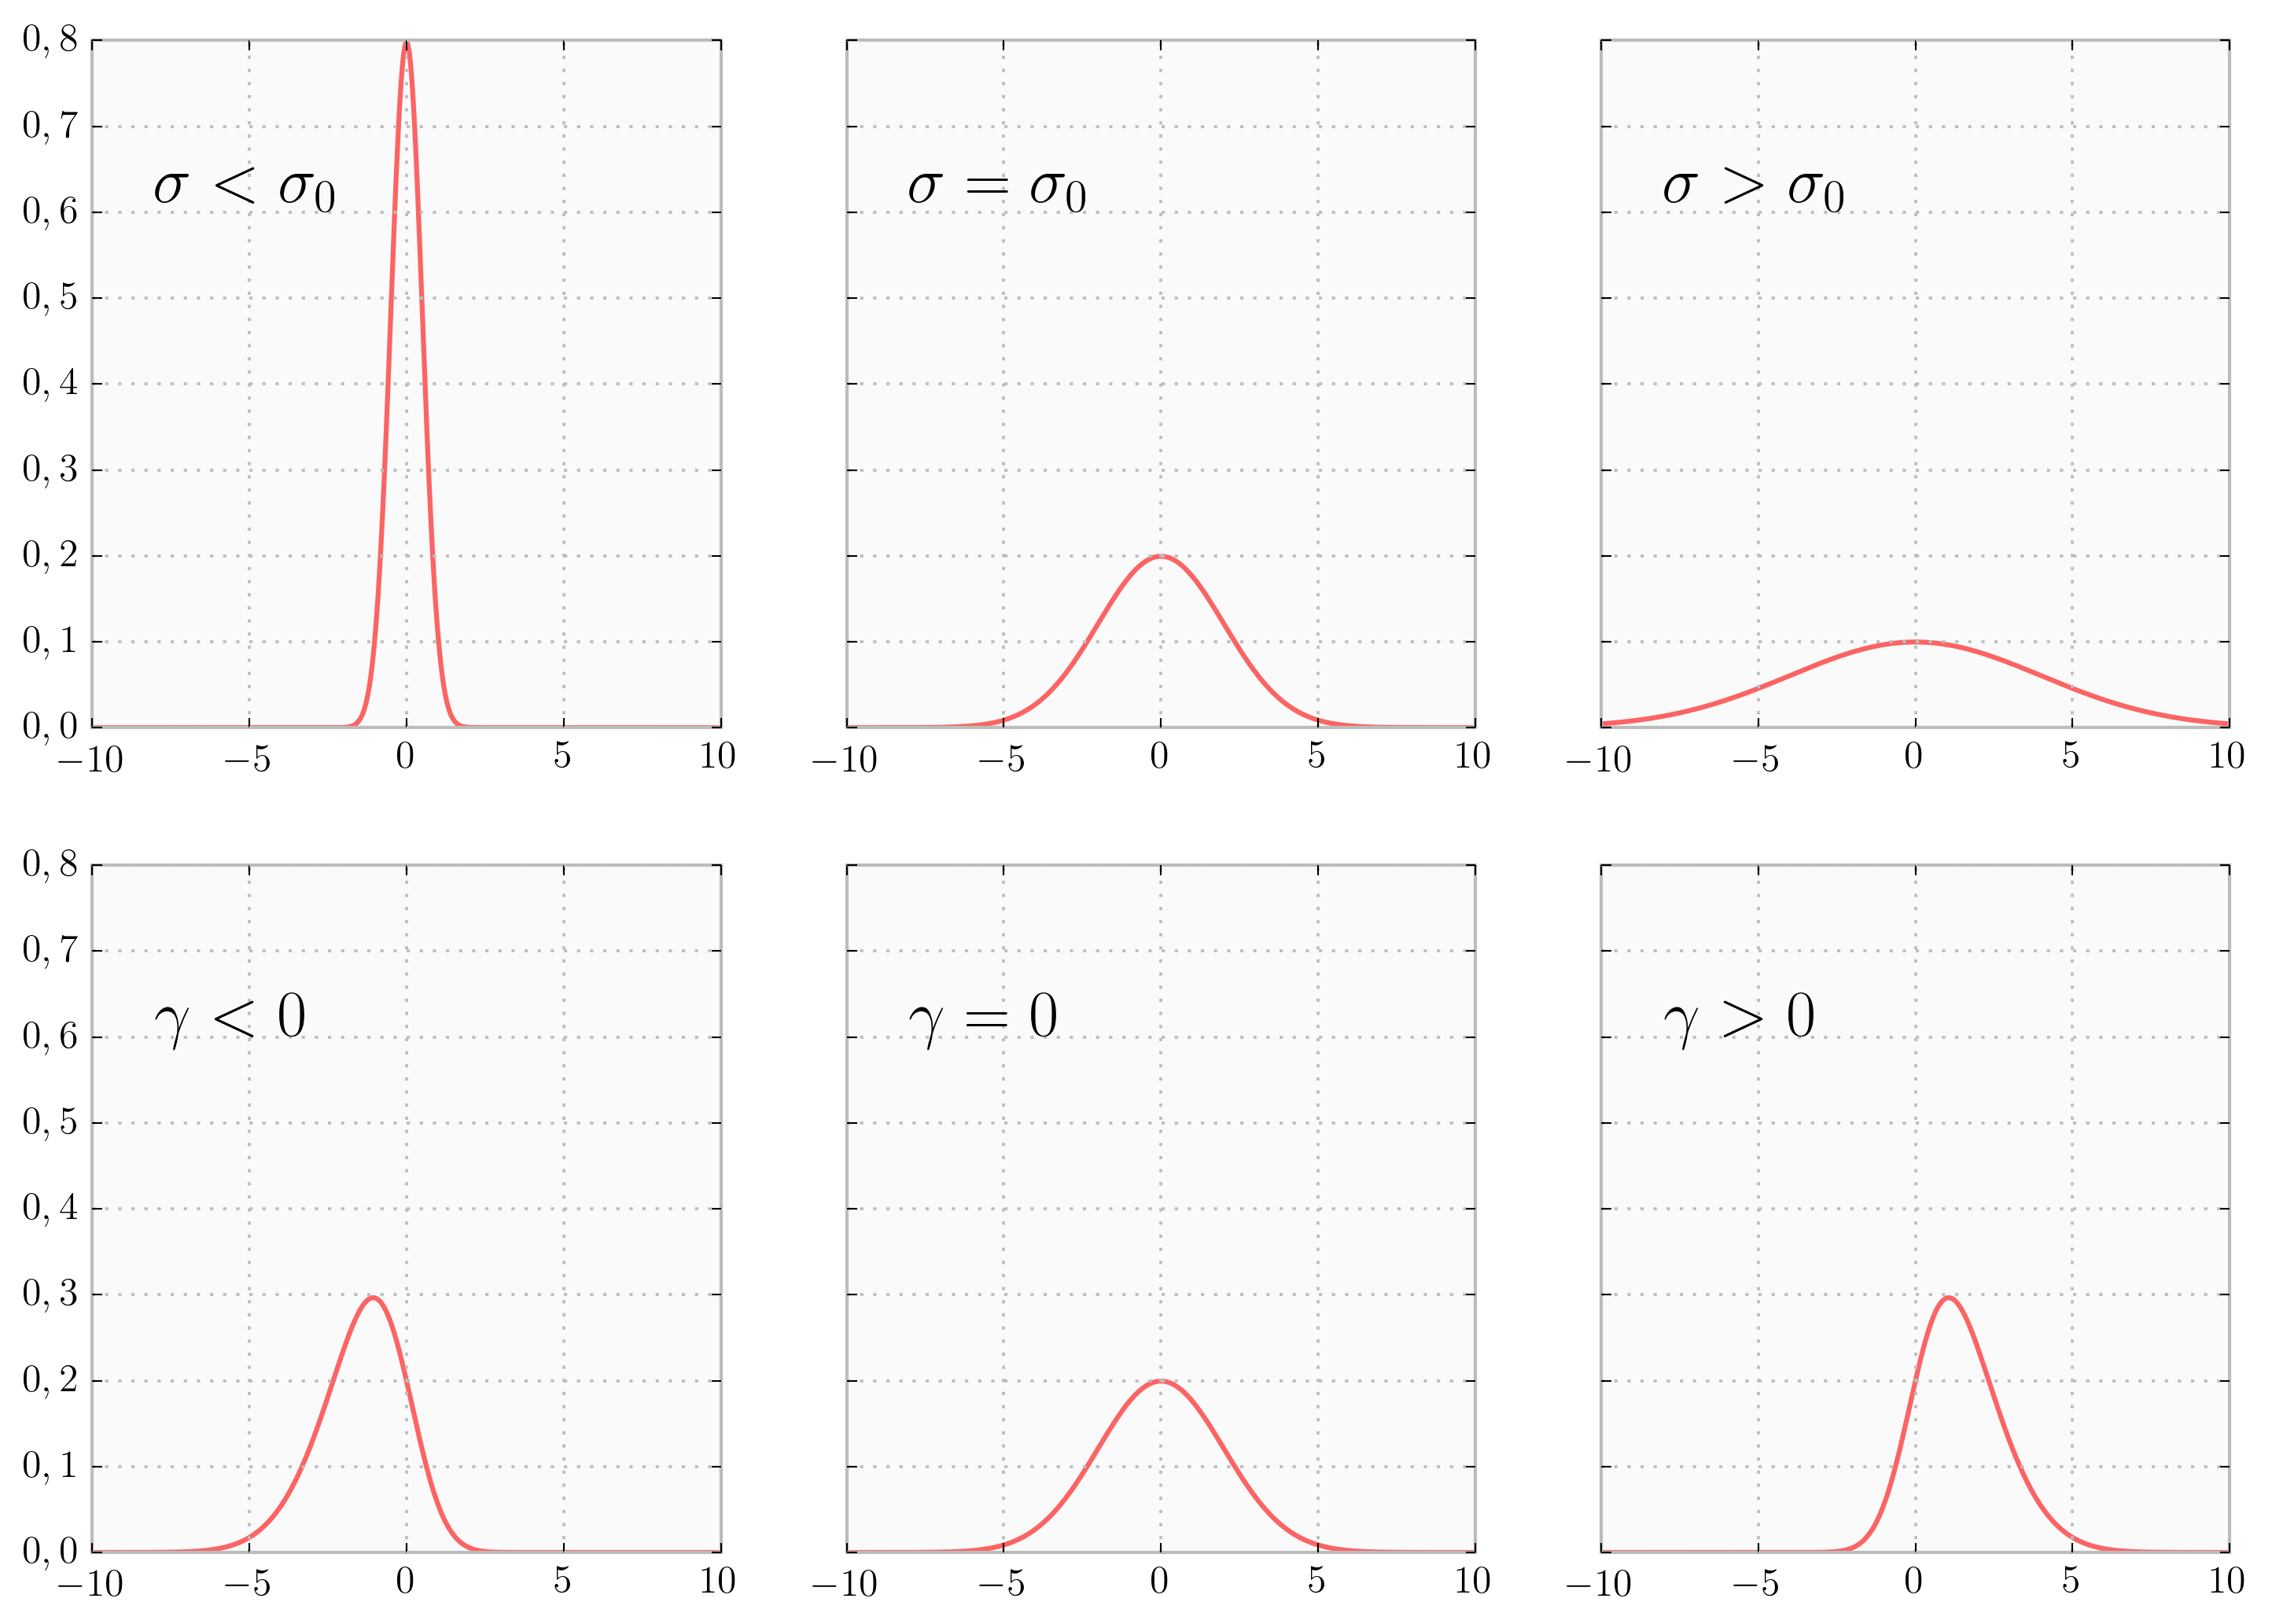

In [3]:
x = np.linspace(-10, 10, 1000)
df = pd.DataFrame({
    'x': x,
    'low_standard_deviation': norm.pdf(x, loc=0, scale=0.5),
    'normal_standard_deviation': norm.pdf(x, loc=0, scale=2.0),
    'high_standard_deviation': norm.pdf(x, loc=0, scale=4.0),
    'negative_skewness': skewnorm.pdf(x, -2, loc=0, scale=2.0),
    'zero_snewness': skewnorm.pdf(x, 0, loc=0, scale=2.0),
    'positive_skewness': skewnorm.pdf(x, 2, loc=0, scale=2.0)
})

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
mean, var, skew, kurt = norm.stats(moments='mvsk')
ax1.plot(x, norm.pdf(x, loc=0, scale=0.5), 'r-', alpha=0.6,
         label='norm pdf')
ax1.text(-8, 0.6, r"$\sigma < \sigma_0$")
ax2.plot(x, norm.pdf(x, loc=0, scale=2.0), 'r-', alpha=0.6,
         label='norm pdf')
ax2.text(-8, 0.6, r"$\sigma = \sigma_0$")
ax3.plot(x, norm.pdf(x, loc=0, scale=4.0), 'r-', alpha=0.6,
         label='norm pdf')
ax3.text(-8, 0.6, r"$\sigma > \sigma_0$")

ax4.plot(x, skewnorm.pdf(x, -2, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax4.text(-8, 0.6, r"$\gamma < 0$")
ax5.plot(x, skewnorm.pdf(x, 0, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax5.text(-8, 0.6, r"$\gamma = 0$")
ax6.plot(x, skewnorm.pdf(x, 2, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax6.text(-8, 0.6, r"$\gamma > 0$")
plt.savefig('figuras/comparacao_desvpad_obliquidade.png')

## Constantes físicas

In [4]:
 # grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev = au_e / ev

## Funções úteis

In [5]:
def dummy_comma(str_number):
    """
    troca separador decimal '.' para ','... é preciso ser assim em
    alguns casos
    """
    c2at = str_number.replace(',', '@@')
    d2c = ctoat.replace('.', ',')
    return d2c.replace('@@', '.')

def as_si(x, ndp):
    """
    coloca um número [x] em no
    """
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# Evolução analítica

In [6]:
def evolucao_analitica(zi=-20.0, zf=20, E=150.0, deltaz=5.0, L=250.0,
                       N=8192):
    """
    Evolui uma onda com energia [E] e desvio padrão [deltaz] da posição 
    inicial [zi] até a posição final [zf]. A evolução ocorre em um 
    espaço unidimensional de lamanho [L] partido em [N] pontos. Esta 
    evolução é pseudo-analítica, pois assume que a integração numérica
    pode ser realizada com grande precisão.

    Parâmetros
    ----------
    zi : float
        Posição inicial em Angstrom
    zf : float 
        Posição final em Angstrom
    E : float
        Energia da onda em eV
    deltaz : float
        Desvio padrão em Angstrom
    L : float
        Compimento do sistema em Angstrom
    N : integer
        Número de pontos em que [L] será partido

    Retorna
    -------
    resumo : dict
        Um dicionário com as seguintes chaves:
        - [z_si] malha de pontos em z (SI)
        - [z_au] malha de pontos em z (AU)
        - [z_ang] malha de pontos em z em Angstrom
        - [wave_initial_au] pacote de onda inicial (AU)
        - [wave_final_au] pacote de onda final (AU)
        - [a_initial] norma inicial <psi|psi>
        - [a_final] norma final <psi|psi>
        - [conservation] 100 * [a_final] / [a_initial]
        - [stdev] desvio padrao final em Angstrom
        - [skewness] obliquidade final
        - [time] o tempo físico para a onda ir de [zi] até [zf]
        - [zf_real] a posição final real que pode diferir um pouco de [zf]
        - também retorna os parâmetros, para facilitar salvar em um .csv

    """
    assert zf > zi  # a onda deve ir da esquerda para a direita
    assert E > 0  # energia nula, a onda fica no lugar
    assert L > 0  # o espaço não pode ser nulo
    assert int(np.log2(N)) == np.log2(N)  # N precisa ser potencia de 2
    assert -L/4 < zf < L/4  # a posição final não pode estar próxima as bordas
    result = locals().copy()

    # mudando para AU
    L_au = L / au2ang
    E_au = E / au2ev
    deltaz_au = deltaz / au2ang
    zi_au = zi / au2ang
    zf_au = zf / au2ang
    k0_au = np.sqrt(2 * E_au)

    # malha direta e recíproca
    z_au = np.linspace(-L_au/2.0, L_au/2.0, N)
    dz_au = np.abs(z_au[1] - z_au[0])
    k_au = fftfreq(N, d=dz_au)

    # tempos
    time_aux = 1e-18
    time = 5e-18

    # valores iniciais
    zm_au = zi_au
    zm_au_aux = zi_au

    # pacote de onda inicial
    PN = 1 / (2 * np.pi * deltaz_au ** 2) ** (1 / 4)
    psi = PN * np.exp(1j*k0_au*z_au-(z_au-zi_au)**2/(4*deltaz_au**2))
    psi_initial = np.copy(psi)  # salva uma copia

    # valores iniciais
    A = A0 = np.sqrt(simps(np.abs(psi) ** 2, z_au))
    zm_au = zi_au
    stdev_au = deltaz_au
    skewness = 0.0

    while np.abs(zm_au - zf_au) >= 0.00001:
        # novo tempo
        t_au = (time) / au_t

        # pacote de onda inicial
        psi = np.copy(psi_initial)

        #####################################################################
        # núcleo da solução pseudo-analítica
        psi_k = fft(psi)
        omega_k = k_au**2 / 2
        psi = ifft(psi_k * np.exp(-1j * omega_k * t_au))
        #####################################################################

        # main indicadores principais
        A2 = simps(np.abs(psi)**2, z_au).real  # quadrado da norma
        A = np.sqrt(A2)  # norma
        psic = np.conjugate(psi)
        zm_au = (simps(psic * z_au * psi, z_au)).real / A2  # <psi|z|psi>

        # ajuste do passo de tempo
        if np.abs(zm_au - zf_au) >= 0.00001:
            if zm_au_aux < zf_au < zm_au or zm_au < zf_au < zm_au_aux:
                aux = (time_aux-time) / 2
            elif zf_au < zm_au and zf_au < zm_au_aux:
                aux = - abs(time_aux-time)
            elif zf_au > zm_au and zf_au > zm_au_aux:
                aux = abs(time_aux-time)

            time_aux = time
            time += aux
            zm_au_aux = zm_au

            continue

        # indicadores secundários
        zm2 = simps(psic * z_au ** 2 * psi, z_au).real / A2
        zm3 = simps(psic * z_au ** 3 * psi, z_au).real / A2
        stdev_au = np.sqrt(np.abs(zm2-zm_au**2))  # desvio padrão
        skewness = (zm3-3*zm_au*stdev_au**2-zm_au**3) / \
            stdev_au**3  # obliquidade
            
    result.update({
        'z_si': z_au * au2ang * 1e-10,
        'z_au': z_au,
        'z_ang': z_au * au2ang,
        'wave_initial': psi_initial,
        'wave_final': psi,
        'a_initial': A0,
        'a_final': A,
        'conservation': 100 * A / A0,
        'stdev': stdev_au * au2ang,
        'skewness': skewness,
        'time': time,
        'zf_real': zm_au_aux * au2ang
    })

    return result

In [7]:
# na verdade já são os valores padrão, colocamos aqui para usar na
# construção do gráfico a seguir
zi=-20.0
zf=20
E=150.0
deltaz=5.0
L=150.0
N=4096
res = evolucao_analitica(zi=zi, zf=zf, E=E, deltaz=deltaz, L=L, N=N)

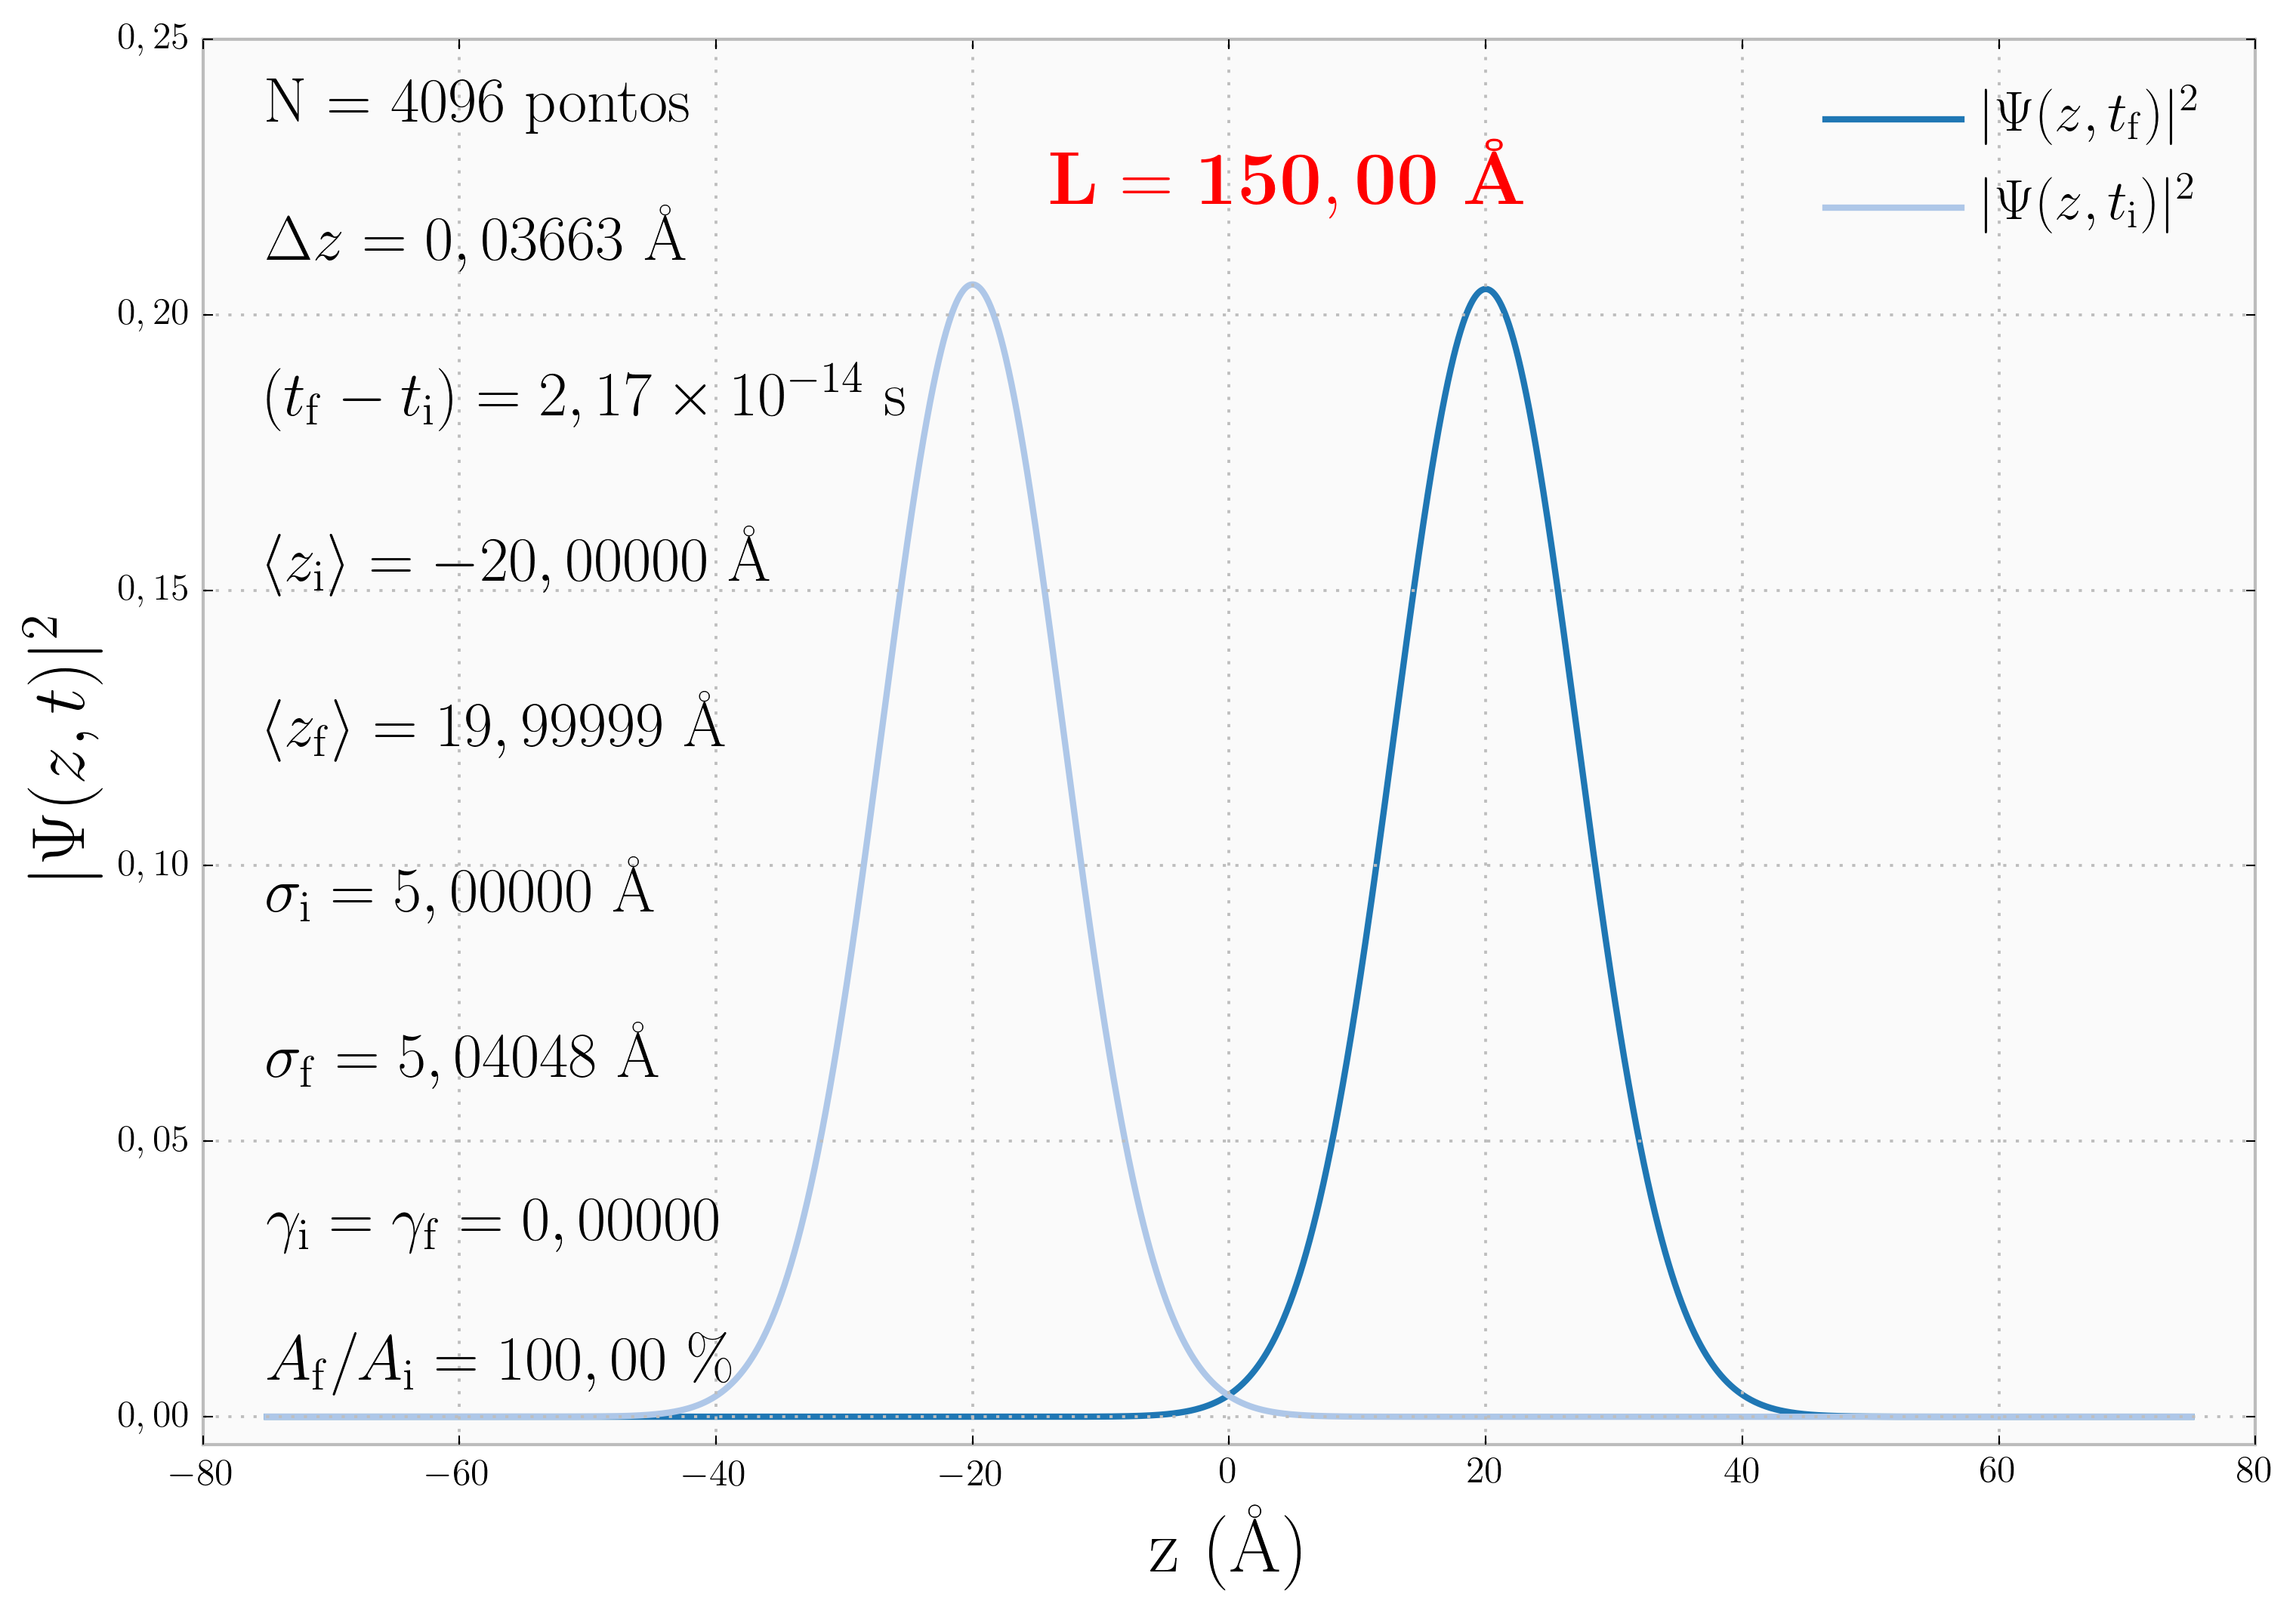

In [8]:
dz = res['z_ang'][1]-res['z_ang'][0]
t_au = res['time'] / au_t
texto_z = -L/2

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([-0.005, 0.25])
ax.text(-14, 0.22, dummy_comma(
    r"$\mathbf{L = %.2f}$ \textbf{\AA}" % (L)), color='red', fontsize=24)
ax.text(texto_z, 0.235, r"N = %d pontos" % N)
ax.text(texto_z, 0.21, dummy_comma(r"$\Delta z = %.5f$ \AA" % (dz)))
ax.text(texto_z, 0.18, dummy_comma(
    r"$(t_\mathrm{f}-t_\mathrm{i}) = %s$ s" % (as_si(t_au * au_t, 2))))
ax.text(texto_z, 0.15, dummy_comma(
    r"$\langle z_\mathrm{i} \rangle = %.5f$ \AA" % (zi)))
ax.text(texto_z, 0.12, dummy_comma(
    r"$\langle z_\mathrm{f} \rangle = %.5f$ \AA" % (res['zf_real'])))
ax.text(texto_z, 0.09, dummy_comma(
    r"$\sigma_\mathrm{i} = %.5f$ \AA" % (deltaz)))
ax.text(texto_z, 0.06, dummy_comma(
    r"$\sigma_\mathrm{f} = %.5f$ \AA" % (res['stdev'])))
ax.text(texto_z, 0.03, dummy_comma(
    r"$\gamma_\mathrm{i} = \gamma_\mathrm{f} = %.5f$" % np.abs(res['skewness'])))
ax.text(texto_z, 0.005, dummy_comma(
    r"$A_\mathrm{f}/A_\mathrm{i} = %.2f$ \%%" % (res['conservation'])))
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel("z (\AA)", fontsize=24)
plt.ylabel(r'$|\Psi (z,t)|^2$', fontsize=24)
line1, = plt.plot(res['z_ang'], np.abs(res['wave_final']),
                  lw=2.0, color=(31 / 255, 119/255, 180/255),
                  label='$|\Psi(z,t_\mathrm{f})|^2$')
line2, = plt.plot(res['z_ang'], np.abs(res['wave_initial']), lw=2.0,
                  color=(174 / 255, 199/255, 232/255),
                  label='$|\Psi(z,t_\mathrm{i})|^2$')
plt.legend(handles=[line1, line2], loc=1)
plt.savefig('figuras/evolucao_pseudo_analitica.png')

# Evolução numérica

In [9]:
def evolucao_numerica(zi=-20.0, zf=20, E=150.0, deltaz=5.0, L=100.0, N=256,
                      dt=1e-20, method='pe'):
    """
    Evolui uma onda com energia [E] e desvio padrão [deltaz] da posição 
    inicial [zi] até a posição final [zf]. A evolução ocorre em um espaço
    unidimensional de lamanho [L] partido em [N] pontos. 
    O método a ser utilizado deve ser escolhido entre Pseudo-Espectral,
    Crank-Nicolson e Runge-Kutta

    Parâmetros
    ----------
    zi : float
        Posição inicial em Angstrom
    zf : float 
        Posição final em Angstrom
    E : float
        Energia da onda em eV
    deltaz : float
        Desvio padrão em Angstrom
    L : float
        Compimento do sistema em Angstrom
    N : integer
        Número de pontos em que [L] será partido
    dt : float
        O passo de tempo em segundos
    method : string
        são aceitos:
        - 'pe' : Pseudo-Espectral
        - 'cn' : Crank-Nicolson
        - 'rk' : Runge-Kutta

    Retorna
    -------
    resumo : dict
        Um dicionário com as seguintes chaves:
        - [z_si] malha de pontos em z (SI)
        - [z_au] malha de pontos em z (AU)
        - [z_ang] malha de pontos em z em Angstrom
        - [wave_initial_au] pacote de onda inicial (AU)
        - [wave_final_au] pacote de onda final (AU)
        - [a_initial] norma inicial <psi|psi>
        - [a_final] norma final <psi|psi>
        - [conservation] 100 * [a_final] / [a_initial]
        - [stdev] desvio padrao final em Angstrom
        - [skewness] obliquidade final
        - [zf_real] a posição final real que pode diferir um pouco de [zf]
        - [program_time] o tempo de processamento
        - [iterations] o número de iterações de tempo [dt]
        - também retorna os parâmetros, para facilitar salvar em um .csv

    """
    assert method in ['pe', 'cn', 'rk']  # metodos aceitos
    assert zf > zi  # a onda deve ir da esquerda para a direita
    assert E > 0  # energia nula, a onda fica no lugar
    assert L > 0  # o espaço não pode ser nulo
    assert int(np.log2(N)) == np.log2(N)  # N precisa ser potencia de 2
    assert -L/4 < zf < L/4  # a posição final não pode estar próxima as bordas
    result = locals().copy()
    
    # mudando para AU
    L_au = L / au2ang
    dt_au = dt / au_t
    E_au = E / au2ev
    deltaz_au = deltaz / au2ang
    zi_au = zi / au2ang
    zf_au = zf / au2ang
    k0_au = np.sqrt(2 * E_au)

    # malha direta e recíproca
    z_au = np.linspace(-L_au/2.0, L_au/2.0, N)
    dz_au = np.abs(z_au[1] - z_au[0])
    k_au = fftfreq(N, d=dz_au)

    # começa a contar o tempo do programa
    time_inicial = time.time()

    # runge-kutta 4th order
    if method == 'rk':
#         # parâmetros instáveis
#         if dt_au / dz_au**2 > 0.5:
#             raise Exception("Unstable parameters")
        alpha = 1j / (2 * dz_au ** 2)
        beta = - 1j / (dz_au ** 2)
        diagonal_1 = [beta] * N
        diagonal_2 = [alpha] * (N - 1)
        diagonals = [diagonal_1, diagonal_2, diagonal_2]
        D = diags(diagonals, [0, -1, 1]).toarray()

        def evolution(p):
            k1 = D.dot(p)
            k2 = D.dot(p + dt_au * k1 / 2)
            k3 = D.dot(p + dt_au * k2 / 2)
            k4 = D.dot(p + dt_au * k3)
            return p + dt_au * (k1 + 2 * k2 + 2 * k3 + k4) / 6

        def evolution_operator(p): return evolution(p)

    # crank-nicolson
    if method == 'cn':
#         # parâmetros instáveis
#         if dt_au / dz_au**2 > 0.5:
#             raise Exception("Unstable parameters")
        alpha = - dt_au * (1j / (2 * dz_au ** 2))/2.0
        beta = 1.0 - dt_au * (- 1j / (dz_au ** 2))/2.0
        gamma = 1.0 + dt_au * (- 1j / (dz_au ** 2))/2.0

        diagonal_1 = [beta] * N
        diagonal_2 = [alpha] * (N - 1)
        diagonals = [diagonal_1, diagonal_2, diagonal_2]
        invB = inv(diags(diagonals, [0, -1, 1]).toarray())

        diagonal_3 = [gamma] * N
        diagonal_4 = [-alpha] * (N - 1)
        diagonals_2 = [diagonal_3, diagonal_4, diagonal_4]
        C = diags(diagonals_2, [0, -1, 1]).toarray()

        D = invB.dot(C)

        def evolution_operator(p): return D.dot(p)

    # split step
    if method == 'pe':
        exp_v2 = np.ones(N, dtype=np.complex_)
        exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au)

        def evolution_operator(p): return \
            exp_v2 * ifft(exp_t * fft(exp_v2 * p))

    # pacote de onda inicial
    PN = 1 / (2 * np.pi * deltaz_au ** 2) ** (1 / 4)
    psi = PN * np.exp(1j*k0_au*z_au-(z_au-zi_au)**2/(4*deltaz_au**2))
    psi_initial = np.copy(psi)  # salva uma cópia

    # norma inicial <psi|psi>
    A = A0 = np.sqrt(simps(np.abs(psi) ** 2, z_au))

    # valores iniciais
    zm_au = zi_au
    stdev_au = deltaz_au
    skewness = 0.0
    iterations = 0
    total_time = time.time() - time_inicial

    while zm_au < zf_au:
        psi = evolution_operator(psi)
        iterations += 1

        # se a onda se mover para o lado oposto, já identifica logo
        # no início e inverte o sentido
        if zm_au < zi_au:
            k0_au *= -1.0
            psi = PN*np.exp(1j*k0_au*z_au-(z_au-zi_au)**2/(4*deltaz**2))
            zm_au = zi_au
            continue

        # indicadores principais
        A2 = simps(np.abs(psi) ** 2, z_au).real
        A = np.sqrt(A2)
        psic = np.conjugate(psi)

        # <psi|z|psi>
        zm_au = (simps(psic * z_au * psi, z_au)).real / A2

        # para de medir o tempo (pode ser o fim)
        total_time = time.time() - time_inicial

        # se <z> >= zf ou o tempo ultrapassou 300 segundos
        if zm_au >= zf_au or total_time > 300:
            # indicadores secundários
            zm2 = simps(psic * z_au ** 2 * psi, z_au).real / A2
            zm3 = simps(psic * z_au ** 3 * psi, z_au).real / A2
            stdev_au = np.sqrt(np.abs(zm2-zm_au**2))
            skewness = (zm3-3*zm_au*stdev_au**2-zm_au**3)/stdev_au**3

            if total_time > 300:
                break

    result.update({
        'zi': zi,
        'zf': zf,
        'E': E,
        'deltaz': deltaz,
        'L': L,
        'N': N,
        'dt': dt,
        'method': method,
        'z_si': z_au * au2ang * 1e-10,
        'z_au': z_au,
        'z_ang': z_au * au2ang,
        'wave_initial': psi_initial,
        'wave_final': psi,
        'a_initial': A0,
        'a_final': A,
        'conservation': 100 * A / A0,
        'stdev': stdev_au * au2ang,
        'skewness': skewness,
        'zf_real': zm_au * au2ang,
        'program_time': total_time,
        'iterations': iterations
    })
    return result

## Avaliação das evoluções numéricas

In [ ]:
methods = ['pe', 'cn', 'rk']
steps = [1e-20, 5e-20, 1e-19, 5e-19, 1e-18, 5e-18, 1e-17, 5e-17, 1e-16, 5e-16]
combs = []

# for method in methods:
#     for L in np.linspace(100,1000,7):
#         for N in [2**n for n in range(8,13)]:
#             for dt in steps:
#                 if dt < 1e-19 and method != 'pe':
#                     continue
#                 combs.append((method, L, N, dt))

for L in np.linspace(100,1000,7):
    for N in [2**n for n in range(8,13)]:
        for dt in steps:
            combs.append((L, N, dt))

res_ana_dict = {}
                
def evolui_combinacao(combination, method):
    try:
        # method, L, N, dt = combination
        L, N, dt = combination
        dz = float(L) / float(N)
        if (dt < 1e-19 and method != 'pe'):
            raise Exception("dt={} muito pequeno para [{}]".format(dt, method))
        elif dz >= 0.8:
            raise Exception("dz={:.3f} muito grande".format(dz))

        res = evolucao_numerica(L=L, N=N, dt=dt, method=method)
        zf_real = res['zf_real']
        if res['program_time'] > 300.0:
            raise Exception("Demorou mais de 300 segundos")
        elif not (-L/2 <= zf_real <= L/2):
            raise Exception("Foi parar fora da malha")
        elif zf_real == -20.0:
            raise Exception("Não se moveu")
        elif zf_real == -20.0:
            raise Exception("Andou para o lado errado")
        
        try:
            res_ana = res_ana_dict[(zf_real, L, N)]
        except:
            res_ana = evolucao_analitica(zf=zf_real, L=L, N=N)
            res_ana_dict[(zf_real, L, N)] = res_ana
            
        for k in res_ana.keys():
            res[k + '_ana'] = res_ana[k]
#         message = "%s: L=%d, N=%d, dt=%.2e, " + \
#                     "A/A0=%.5f, S=%.4f, G=%.4f, " + \
#                     "A/A0_ana=%.5f, S_ana=%.4f, G_ana=%.4f, " + \
#                     "time=%.5f"
#         message = message % (method, L, N, dt,\
#             res['conservation'], res['stdev'], \
#             res['skewness'], res['conservation_ana'], \
#             res['stdev_ana'], res['skewness_ana'],
#             res['program_time'])
        message = "%s: L=%d, N=%d, dt=%.2e, " + \
            "A/A0=%.5f, S=%.4f, G=%.4f, time=%.5f"
        message = message % (method, L, N, dt,
                             res['conservation'], res['stdev'],
                             res['skewness'], res['program_time'])
        print(message)
        return res
    except Exception as err:
        print(err)
        print("Falha em %s: L=%d, N=%d, dt=%.2e" % (method, L, N, dt))
        return {}


# pool = Pool(processes=2)
# results = pd.DataFrame(pool.map(evolui_combinacao, combs))

# colunas para serem salvas
cols = ['E', 'E_ana', 'L', 'L_ana', 'N', 'N_ana', 'a_final', 'a_final_ana',
        'a_initial', 'a_initial_ana', 'conservation', 'conservation_ana',
        'deltaz', 'deltaz_ana', 'dt', 'iterations', 'method', 'program_time',
        'skewness', 'skewness_ana', 'stdev', 'stdev_ana', 'time_ana']

for method in methods:
    ms = [method] * len(combs)
    results = pd.DataFrame(list(map(evolui_combinacao, combs, ms))).dropna()
    results[cols].to_csv('saidas/onda_plana_resultados_{}.csv'.format(
        method), sep=",", index=False)

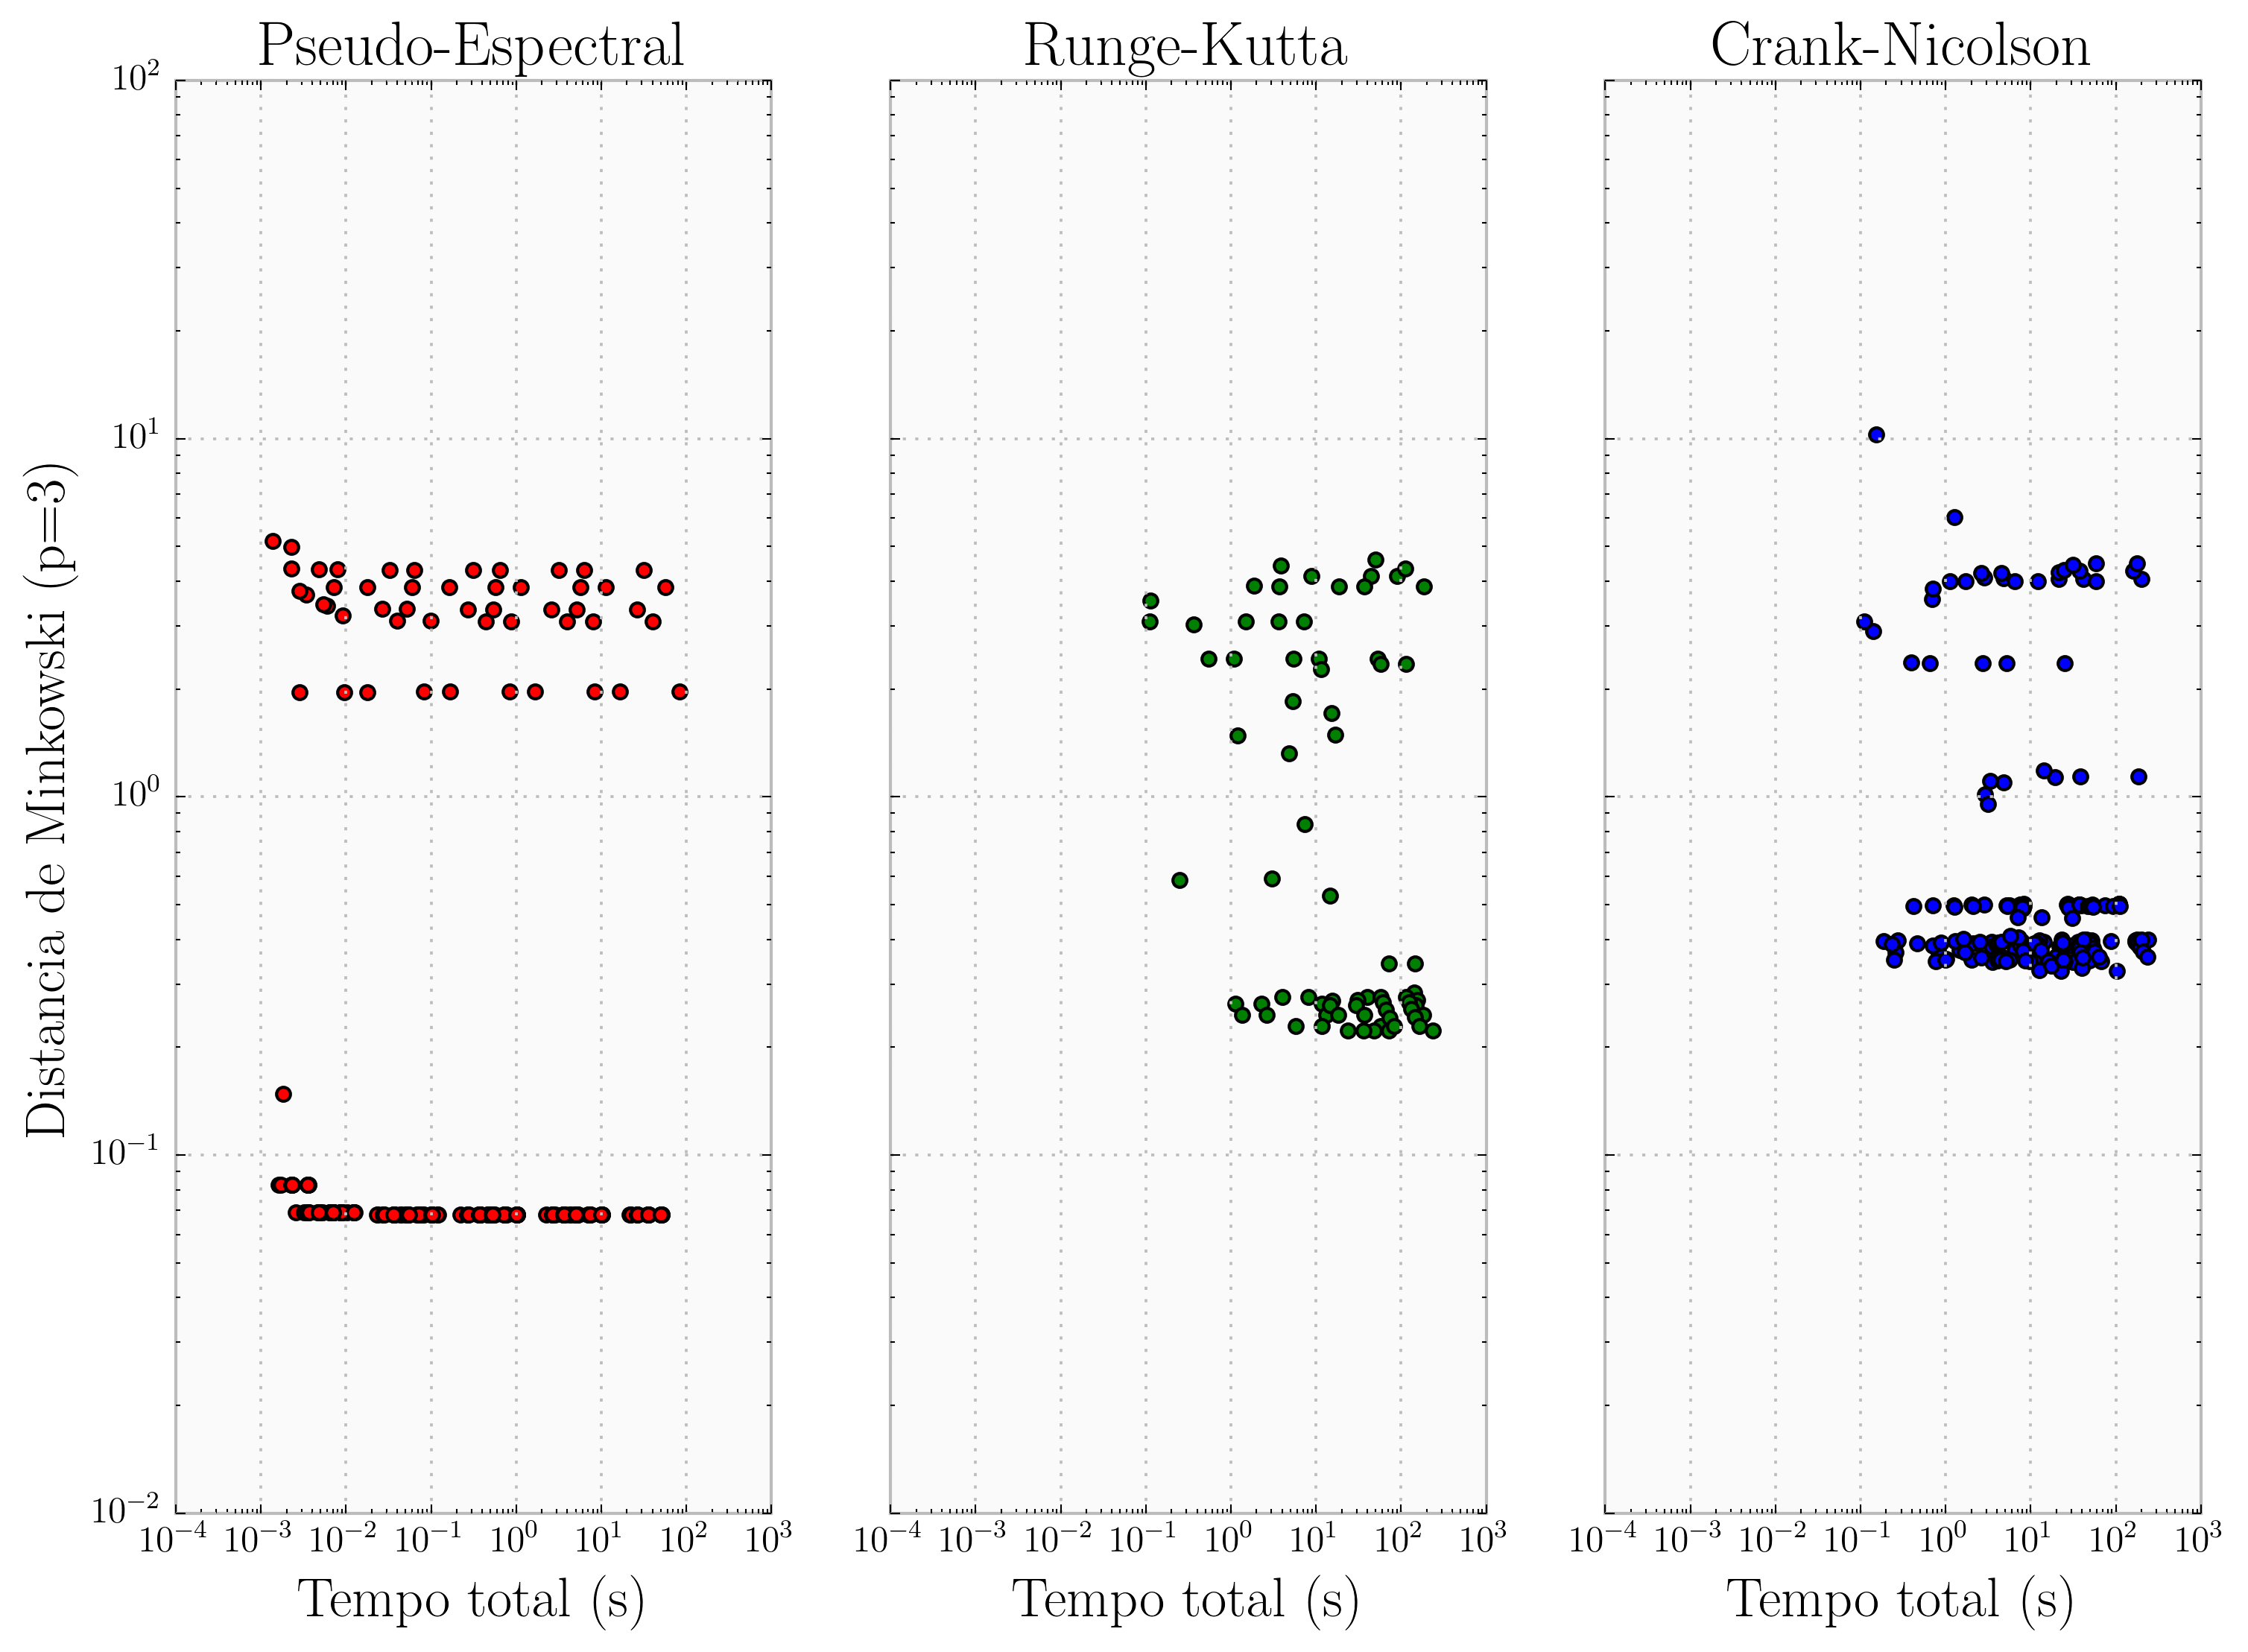

In [11]:
pe = pd.read_csv('saidas/onda_plana_resultados_pe.csv')
rk = pd.read_csv('saidas/onda_plana_resultados_rk.csv')
cn = pd.read_csv('saidas/onda_plana_resultados_cn.csv')

pec = pe.copy()
rkc = rk.copy()
cnc = cn.copy()

scaler = StandardScaler()
cols = ['stdev', 'skewness', 'a_final', 'stdev_ana', 'skewness_ana',
        'a_final_ana']

pec[cols] = scaler.fit_transform(pec[cols])
rkc[cols] = scaler.fit_transform(rkc[cols])
cnc[cols] = scaler.fit_transform(cnc[cols])

p = 3
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True);

with pd.plotting.plot_params.use('x_compat', True):
    pec['minkowski'] = pec.apply(lambda l: cdist(XA=[[l.a_final,l['stdev'],
                                                      l['skewness']]],
                                                 XB=[[l.a_final_ana,
                                                      l.stdev_ana,
                                                      l.skewness_ana]],
                                                 metric='minkowski',
                                                 p=p)[0][0], axis=1)
    pec.plot(x='program_time', y='minkowski', kind='scatter', loglog=True,
             color='r', ax=ax1, sharex=True, sharey=True)

    rkc['minkowski'] = rkc.apply(lambda l: cdist(XA=[[l.a_final,l['stdev'],
                                                      l['skewness']]],
                                                 XB=[[l.a_final_ana,
                                                      l.stdev_ana,
                                                      l.skewness_ana]],
                                                 metric='minkowski',
                                                 p=p)[0][0], axis=1)
    rkc.plot(x='program_time', y='minkowski', kind='scatter', loglog=True,
             color='g', ax=ax2, sharex=True, sharey=True)
    cnc['minkowski'] = cnc.apply(lambda l: cdist(XA=[[l.a_final,l['stdev'],
                                                      l['skewness']]],
                                                 XB=[[l.a_final_ana,
                                                      l.stdev_ana,
                                                      l.skewness_ana]],
                                                 metric='minkowski',
                                                 p=p)[0][0], axis=1)
    cnc.plot(x='program_time', y='minkowski', kind='scatter', loglog=True,
             color='b', ax=ax3, sharex=True, sharey=True)

ax1.title.set_text('Pseudo-Espectral')
ax2.title.set_text('Runge-Kutta')
ax3.title.set_text('Crank-Nicolson')
ax1.set_ylabel('Distancia de Minkowski (p=3)')
ax2.set_ylabel('Distancia de Minkowski (p=3)')
ax3.set_ylabel('Distancia de Minkowski (p=3)')
ax1.set_xlabel('Tempo total (s)')
ax2.set_xlabel('Tempo total (s)')
ax3.set_xlabel('Tempo total (s)')

plt.savefig('figuras/onda_plana_comparacao_minkowski.png', bbox_inches='tight')